In [6]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [7]:

class super_reversion_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            super_trend = SuperTrend(
                df['high'], 
                df['low'], 
                df['close'], 
                params["st_short_atr_window"], 
                params["st_short_atr_multiplier"]
            )
            
            df['super_trend_direction'] = super_trend.super_trend_direction()
            df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=params["short_ema_window"])
            df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=params["long_ema_window"])
            
            df = get_n_columns(df, ["super_trend_direction", "ema_short", "ema_long"], 1)
            
            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []

        for pair in self.df_list:
            params = self.parameters_obj[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_limit"] = False
            df["close_long_limit"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            # -- Populate open long limit --
            df.loc[
                (df['n1_ema_short'] >= df['n1_ema_long']) 
                & (df['n1_super_trend_direction'] == True) 
                & (df['n1_ema_short'] > df['low']) 
                , "open_long_limit"
            ] = True
            
            # -- Populate close long limit --
            df.loc[
                ((df['n1_ema_short'] <= df['n1_ema_long'])
                | (df['n1_super_trend_direction'] == False))
                & (df['n1_ema_short'] < df['high'])
                , "close_long_limit"
            ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_limit']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_limit']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        usd_pct_remaining = 1
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * taker_fee
                    temp_wallet += close_size - current_positions[pos]['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            if len(current_positions) > 0:
                position_to_close = set(current_positions).intersection(set(close_long_row))
                for pos in position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['n1_ema_short']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Market",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos]   
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0:
                for pos in open_long_row:
                    if pos not in current_positions:
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['n1_ema_short']
                        pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                        usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "LONG"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True

In [8]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.3,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 20,
        "long_ema_window": 400
    },
    "ETH/USDT": {
        "wallet_exposure": 0.1,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "LTC/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 5,
        "long_ema_window": 400
    },
    "SOL/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 40,
        "long_ema_window": 400
    },
    "LUNA/USDT": {
        "wallet_exposure": 0.2,
        "st_short_atr_window": 15,
        "st_short_atr_multiplier": 5,
        "short_ema_window": 15,
        "long_ema_window": 400
    },
}

pair_list = list(params_coin.keys())
tf = '1h'
oldest_pair = "BTC/USDT"

df_list = {}
for pair in pair_list:
    df = get_historical_from_db(ccxt.binance(), pair, tf, path="../../database/")
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-05-06 02:00:00,36311.57,36553.33,36311.56,36433.40,1891.821880
2022-05-06 03:00:00,36433.41,36474.60,36360.31,36461.82,1038.054980
2022-05-06 04:00:00,36461.81,36472.91,36287.46,36435.42,1090.067770


Period: [2017-08-17 00:00:00] -> [2022-05-06 00:00:00]
Initial wallet: 1000.0 $
Trades on 5 pairs

--- General Information ---
Final wallet: 63635.15 $
Performance vs US dollar: 6263.52 %
Sharpe Ratio: 2.47
Worst Drawdown T|D: -16.73% | -19.17%
Buy and hold performance: 744.16 %
Performance vs buy and hold: 653.83 %
Total trades on the period: 541
Global Win rate: 38.26 %
Average Profit: 4.65 %

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
132     BTC/USDT       400.81 %         3.04 %       -10.26 %        44.78 %        42.42 %
135     ETH/USDT        467.4 %         3.46 %       -15.18 %        86.18 %        37.78 %
151     LTC/USDT        388.9 %         2.58 %       -10.37 %        61.17 %        32.45 %
47      SOL/USDT 

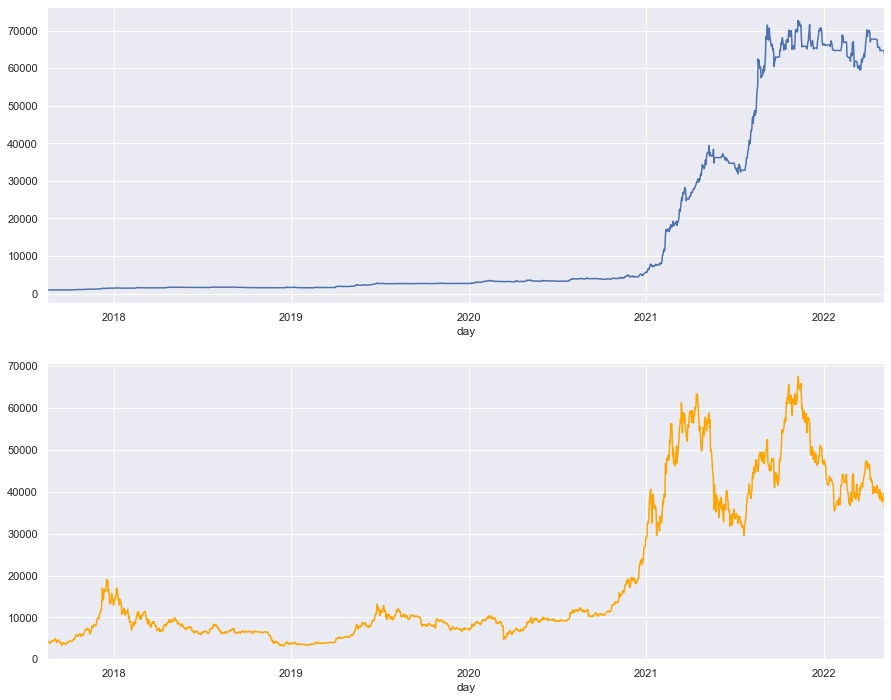

In [9]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [11]:
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,usd_remaining,trade_result,trade_result_pct,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,
2017-09-07 20:00:00,BTC/USDT,2017-09-07 20:00:00,2017-09-09 05:00:00,LONG,Market,Market,4628.147993,4321.670966,0.0,0.0,300.000000,280.133931,980.133931,980.133931,-19.866069,-0.066220,980.133931,0.000000,0.000000
2017-09-26 05:00:00,ETH/USDT,2017-09-26 05:00:00,2017-09-29 11:00:00,LONG,Market,Market,289.477028,295.638073,0.0,0.0,98.013393,100.099448,982.219986,688.179806,2.086055,0.021283,982.219986,0.000000,0.000000
2017-09-26 04:00:00,BTC/USDT,2017-09-26 04:00:00,2017-10-03 21:00:00,LONG,Market,Market,3881.760961,4290.339609,0.0,0.0,294.040179,324.989674,1013.169480,1013.169480,30.949494,0.105256,1013.169480,0.000000,0.000000
2017-10-08 22:00:00,ETH/USDT,2017-10-08 22:00:00,2017-10-10 10:00:00,LONG,Market,Market,310.097279,300.992266,0.0,0.0,101.316948,98.342100,1010.194633,706.243789,-2.974848,-0.029362,1013.169480,2.974848,0.002936
2017-10-15 03:00:00,ETH/USDT,2017-10-15 03:00:00,2017-10-15 21:00:00,LONG,Market,Market,339.087119,333.914125,0.0,0.0,100.891970,99.352797,1008.655460,704.704616,-1.539172,-0.015256,1013.169480,4.514020,0.004455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-21 15:00:00,LTC/USDT,2022-04-21 15:00:00,2022-04-22 02:00:00,LONG,Market,Market,113.204118,107.568973,0.0,0.0,13504.896401,12832.641351,66873.760991,33089.985952,-672.255051,-0.049779,71113.277222,4239.516231,0.059616
2022-04-20 15:00:00,LUNA/USDT,2022-04-20 15:00:00,2022-04-22 04:00:00,LONG,Market,Market,95.300888,93.538431,0.0,0.0,13526.430437,13276.277981,66623.608535,46366.263933,-250.152456,-0.018494,71113.277222,4489.668687,0.063134
2022-04-21 16:00:00,BTC/USDT,2022-04-21 16:00:00,2022-04-23 12:00:00,LONG,Market,Market,41974.011325,39700.494417,0.0,0.0,20257.344602,19160.108145,65526.372078,65526.372078,-1097.236457,-0.054165,71113.277222,5586.905144,0.078563


----- 2017 Cumulative Performances: 45.32% -----


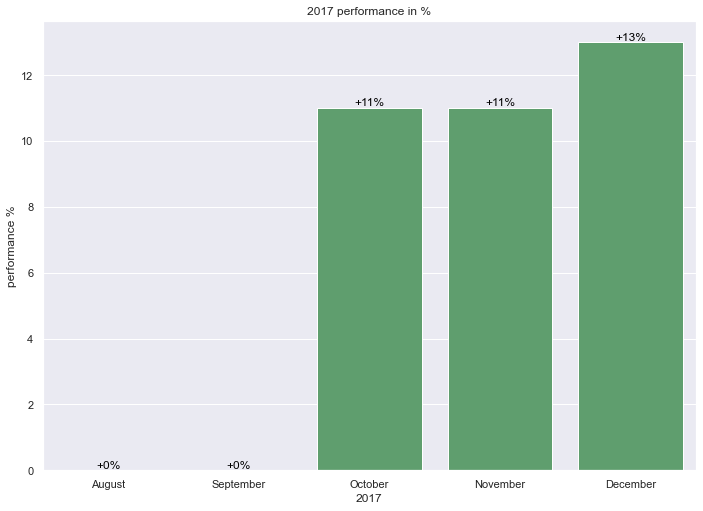

----- 2018 Cumulative Performances: 14.55% -----


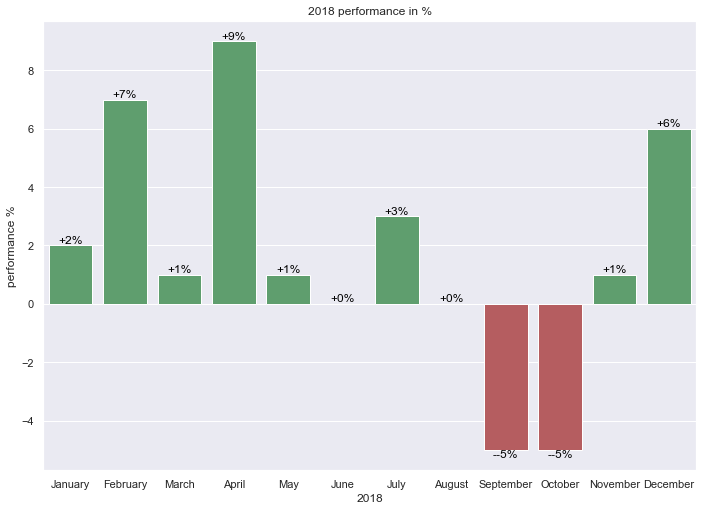

----- 2019 Cumulative Performances: 65.79% -----


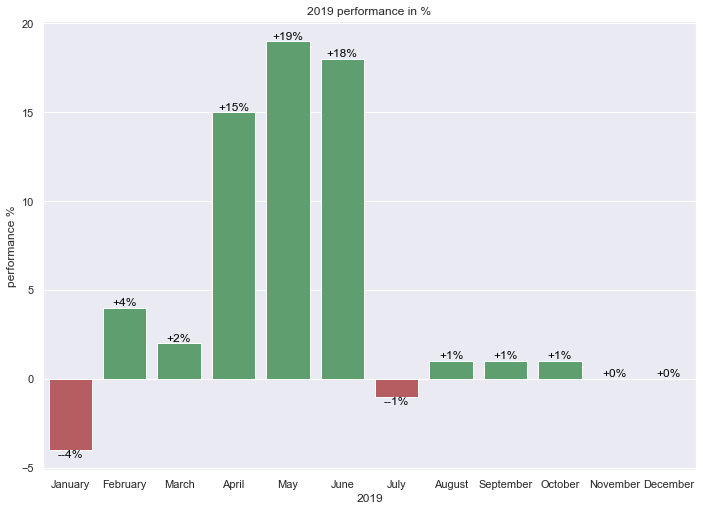

----- 2020 Cumulative Performances: 112.95% -----


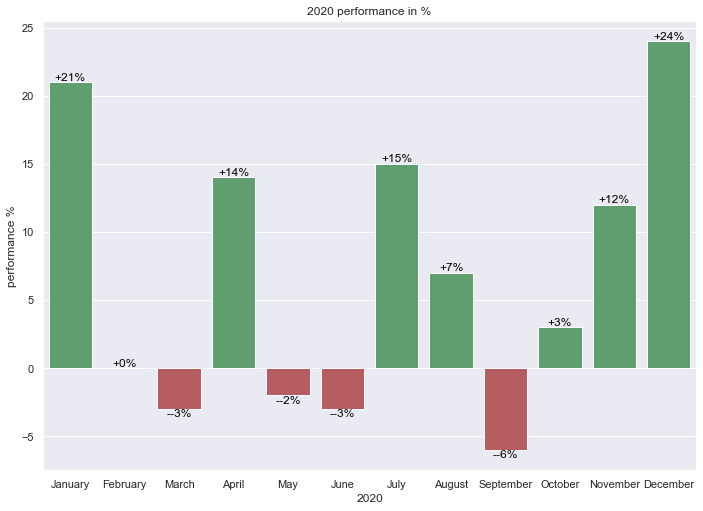

----- 2021 Cumulative Performances: 1064.77% -----


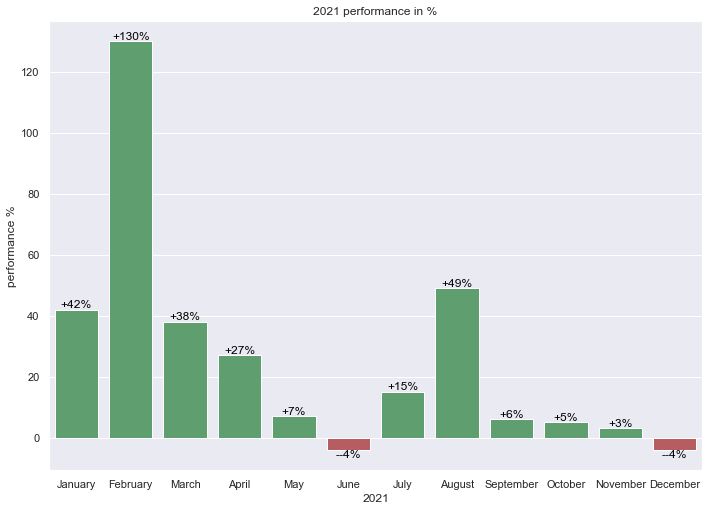

----- 2022 Cumulative Performances: -4.17% -----


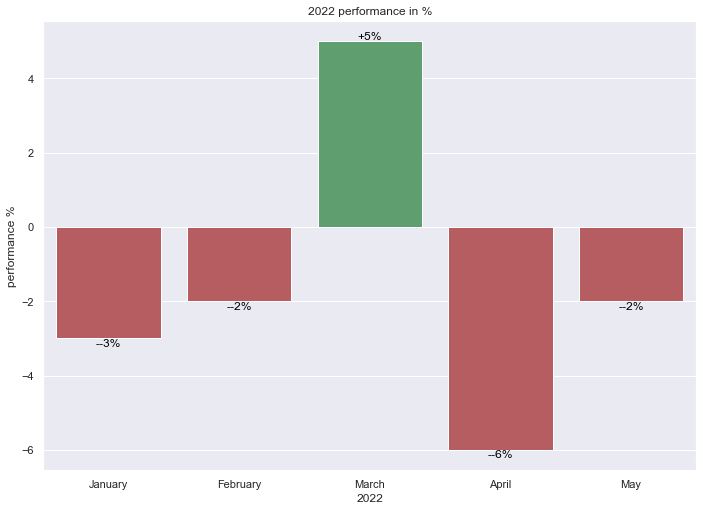

In [10]:
plot_bar_by_month(df_days=df_days)